# Stable Diffusion Checkpoint Inference

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/model-inference/Stable-Diffusion-CKPT-Inference/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=model-inference/Stable-Diffusion-CKPT-Inference/index.ipynb)

## Introduction 

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) is a state of the art text-to-image model that generates images from text and was developed as an open source alternative to [DALL·E 2](https://openai.com/dall-e-2/). It is based on a [Diffusion Probabilistic Model](https://arxiv.org/abs/2102.09672) and uses a [Transformer](https://arxiv.org/abs/1706.03762) to generate images from text.

This example demonstrates how to use stable diffusion using a finetuned model and run inference on it. The first section describes the development of the code and the container. The second section demonstrates how to convert your model weights to ckpt. The third section demonstrates how to run the job using [Bacalhau](https://www.bacalhau.org/). the first section is optinal as users don't need to build their own containers to use their own custom model

The following image is an example generated by fine-tuned model,it was finetuned on bacalhau to learn how to finetune your own stable diffusion model
refer https://docs.bacalhau.org/examples/model-training/Stable-Diffusion-Dreambooth

TLDR

```
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
-v QmUCJuFZ2v7KvjBGHRP2K1TMPFce3reTkKVGF2BJY5bXdZ:/DavidAronchick.ckpt \
jsacex/stable-diffusion-ckpt \
-- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of aronchick drinking coffee" --plms --ckpt ../DavidAronchick.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs
```

![](https://i.imgur.com/xnt79th.png)


## Buiding a docker container (Optional)

Note: you can skip this step and move to Running on bacalhau since you don't need build your own container
you can use the prebuilt container 

Prerequisites
- NVIDIA GPU
- CUDA drivers installed
- NVIDIA docker installed

First we will create a `Dockerfile` to containerize the code for inference. 

```Dockerfile
FROM  pytorch/pytorch:1.13.0-cuda11.6-cudnn8-runtime

WORKDIR /

RUN apt update &&  apt install -y git

RUN git clone https://github.com/runwayml/stable-diffusion.git

WORKDIR /stable-diffusion

RUN conda env create -f environment.yaml

SHELL ["conda", "run", "-n", "ldm", "/bin/bash", "-c"]

RUN pip install opencv-python

RUN apt update

RUN apt-get install ffmpeg libsm6 libxext6 libxrender-dev  -y
```


This container is using the `pytorch/pytorch:1.13.0-cuda11.6-cudnn8-runtime` image and the working directory is set. Next the Dockerfile installs the same dependencies from earlier in this notebook. Then we add our custom code and pull the dependent repositories.


To Build the docker container run the docker build command

```
docker build -t <hub-user>/<repo-name>:<tag> .
```

Please replace

<hub-user> with your docker hub username, If you don’t have a docker hub account Follow these instructions to create docker account, and use the username of the account you created

<repo-name> This is the name of the container, you can name it anything you want

<tag> This is not required but you can use the latest tag

After you have build the container, the next step is to test it locally and then push it docker hub

Now you can push this repository to the registry designated by its name or tag.

```
 docker push <hub-user>/<repo-name>:<tag>
```


After the repo image has been pushed to docker hub, we can now use the container for running on bacalhau but before that you need to check whether your model is a ckpt file or not, if your model is a ckpt file you can skip to the running on bacalhau if not the next section describes how to convert your model into the ckpt format


## Converting model weights to CKPT


donwloading the convert script
```
wget -q https://github.com/TheLastBen/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
```
converting the model weights into CKPT format, the --half flag cuts the size of the output model from 4GB to 2GB
```
python convert_diffusers_to_original_stable_diffusion.py --model_path <path-to-the-model-weights>  --checkpoint_path <path-to-save-the-checkpoint>/model.ckpt --half
```

## Running on bacalhau

To do inference on your own checkpoint on bacalhau you need to first upload it to IPFS

this can be done using a number of IPFS pinning services

In this case we will be using 
### [NFT.Storage](https://nft.storage/) (Recommneded Option)

[Upload files and directories with NFTUp](https://nft.storage/docs/how-to/nftup/) 

To upload your dataset using NFTup just drag and drop your directory it will upload it to IPFS

![](https://i.imgur.com/g3VM2Kp.png)

After the checkpoint file has been uploaded copy its CID

In [ ]:
!curl -sL https://get.bacalhau.org/install.sh | bash

Your system is linux_amd64
No BACALHAU detected. Installing fresh BACALHAU CLI...
Getting the latest BACALHAU CLI...
Installing v0.3.11 BACALHAU CLI...
Verified OK
Extracting tarball ...
NOT verifying Bin
bacalhau installed into /usr/local/bin successfully.
Client Version: v0.3.11
Server Version: v0.3.11


The following command mounts the model from IPFS to the docker container and then runs the script to which we specify arguments

In [ ]:
%%bash --out job_id
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--wait \
--id-only \
-v QmUCJuFZ2v7KvjBGHRP2K1TMPFce3reTkKVGF2BJY5bXdZ:/DavidAronchick.ckpt \
jsacex/stable-diffusion-ckpt \
-- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of aronchick drinking coffee" --plms --ckpt ../DavidAronchick.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs 

Structure of the command

--gpu 1 here we request 1 GPU


-v QmUCJuFZ2v7KvjBGHRP2K1TMPFce3reTkKVGF2BJY5bXdZ:/DavidAronchick.ckpt 

: -v < CHECKPOINT-CID > :/ < Path-to-mount-the-checkpoint >


-- conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt "a photo of aronchick drinking coffee" --plms --ckpt ../DavidAronchick.ckpt --n_samples 1 --skip_grid --outdir ../outputs  

since we are using conda we need to specify the name of the enviroment which we are going to use in this case its ldm

and the later part is running the python script
 scripts/txt2img.py
 we provide it the following parameters
  the prompt you need to specify the session name in the prompt eg the session name here is aronchick
 
 --prompt "a photo of aronchick drinking coffee"

and then specify the sampler you want to use in this case we will use the plms sampler

and then specify the path to our checkpoint
--ckpt ../DavidAronchick.ckpt

 --n_samples 1 
and then the no of samples we want to produce

skip creating a grid of images
--skip_grid 

path to store the outputs
--outdir ../outputs  

The output generated on the same prompt will always be the same for different outputs on the same prompt set the seed parameter to random
--seed $RANDOM



In [ ]:
%env JOB_ID={job_id}

env: JOB_ID=6980c043-f8f8-471b-b82b-d71b6a30945e


In [ ]:
%%bash
bacalhau list --id-filter ${JOB_ID} --wide

 CREATED            ID                                    JOB                                                                                                                                                                                                                                              STATE      VERIFIED  PUBLISHED                                            
 22-11-14-06:33:36  6980c043-f8f8-471b-b82b-d71b6a30945e  Docker jsacex/stable-diffusion-ckpt conda run --no-capture-output -n ldm python scripts/txt2img.py --prompt a photo of aronchick drinking coffee --plms --ckpt ../DavidAronchick.ckpt --skip_grid --n_samples 1 --skip_grid --outdir ../outputs  Completed            /ipfs/QmVoxqatkEux7NjSZavrJ2gZ9zZG4hxtCjeFJcFWDQcqc1 


Where it says "Completed", that means the job is done, and we can get the results.

To find out more information about your job, run the following command:


In [ ]:
%%bash
bacalhau describe ${JOB_ID}

## Downloading the results

In [ ]:
%%bash
rm -rf results && mkdir -p results
bacalhau get $JOB_ID --output-dir results

Fetching results of job '6980c043-f8f8-471b-b82b-d71b6a30945e'...
Results for job '6980c043-f8f8-471b-b82b-d71b6a30945e' have been written to...
results


2022/11/14 06:37:14 failed to sufficiently increase receive buffer size (was: 208 kiB, wanted: 2048 kiB, got: 416 kiB). See https://github.com/lucas-clemente/quic-go/wiki/UDP-Receive-Buffer-Size for details.


Viewing the outputs

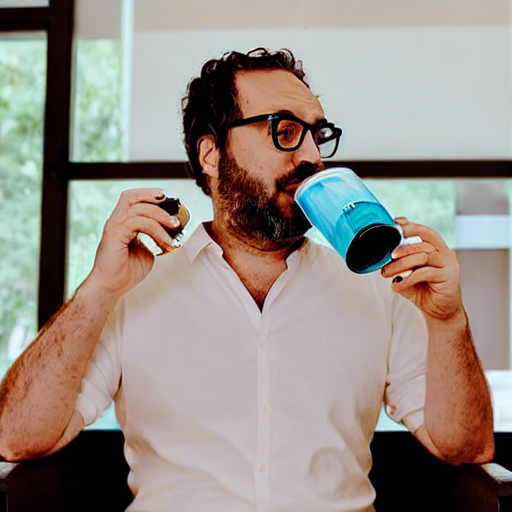

In [ ]:
import IPython.display as display
display.Image("results/combined_results/outputs/samples/00001.png")